# Notebook 02 – Entrenamiento de Modelos RNN (LSTM/GRU)
Versión lista para pegar en Jupyter – Español + Inglés

Incluye:

Carga correcta desde data/raw_npy/

Uso del demo GitHub (200 muestras por clase) o Zenodo (120k)

Carga automática de configuraciones JSON

Construcción del modelo

Entrenamiento con métricas

Guardado del modelo y metadatos

Estructura limpia y modular (como un artículo reproducible)

In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [15]:

# =========================
# CONFIGURACIÓN GENERAL
# =========================

# Directorio base del repositorio
BASE_DIR = "/Users/armandobecerril/PhD/MSL-150"

# Nº de frames por secuencia y muestras por clase
frames = 30
samples = 800   # usa 800 , 200 o 20 para dataset completo de Zenodo(800), 20 si trabajas solo con el subset

# -------------------------
# RUTAS DE DATOS
# -------------------------

# Ruta donde están los .npy completos descargados desde Zenodo
# Estructura esperada: data/raw_npy/<palabra>/<secuencia>/<frame>.npy
DATA_PATH = os.path.join(BASE_DIR, "data", "raw_npy")

# Ruta al archivo de términos (diccionario de vocabulario)
TERMS_PATH = os.path.join(BASE_DIR, "data", "dictionary", "terms.txt")

# -------------------------
# RUTAS DE MODELOS Y MÉTRICAS
# -------------------------

# Carpeta para guardar modelos entrenados
MODELS_BASE_DIR = os.path.join(BASE_DIR, "models", "trained_models")

# Carpeta para guardar el CSV de métricas
PERFORMANCE_DIR = os.path.join(BASE_DIR, "docs", "performance")

os.makedirs(MODELS_BASE_DIR, exist_ok=True)
os.makedirs(PERFORMANCE_DIR, exist_ok=True)

print("BASE_DIR        :", BASE_DIR)
print("DATA_PATH       :", DATA_PATH)
print("TERMS_PATH      :", TERMS_PATH)
print("MODELS_BASE_DIR :", MODELS_BASE_DIR)
print("PERFORMANCE_DIR :", PERFORMANCE_DIR)


BASE_DIR        : /Users/armandobecerril/PhD/MSL-150
DATA_PATH       : /Users/armandobecerril/PhD/MSL-150/data/raw_npy
TERMS_PATH      : /Users/armandobecerril/PhD/MSL-150/data/dictionary/terms.txt
MODELS_BASE_DIR : /Users/armandobecerril/PhD/MSL-150/models/trained_models
PERFORMANCE_DIR : /Users/armandobecerril/PhD/MSL-150/docs/performance


In [3]:
# Leer términos desde TERMS_PATH y construir el diccionario de vocabulario
videos_dict_aug = {}

with open(TERMS_PATH, 'r') as f:
    for line in f:
        term = line.strip()
        if term:
            videos_dict_aug[term] = samples  # p.ej. 800 , 200 o 20 según tu escenario

print("Número de términos en videos_dict_aug:", len(videos_dict_aug))
list(videos_dict_aug.items())[:10]


Número de términos en videos_dict_aug: 150


[('hospital', 800),
 ('si', 800),
 ('duro', 800),
 ('lunes', 800),
 ('perro', 800),
 ('cansado', 800),
 ('ayer', 800),
 ('yo', 800),
 ('nosotros', 800),
 ('beber', 800)]

In [4]:
# ---------------------------------------------------------
# Carga de secuencias (X) y etiquetas (y) desde los .npy
# ---------------------------------------------------------

# Mapeo de las acciones a números
label_map = {label: num for num, label in enumerate(videos_dict_aug.keys())}

sequences, labels = [], []

for action, n_sequences in videos_dict_aug.items():
    action_path = os.path.join(DATA_PATH, action)  # carpeta de la acción

    for sequence in range(n_sequences):
        sequence_path = os.path.join(action_path, str(sequence))  # carpeta de la secuencia
        window = []

        for frame_num in range(frames):  # normalmente 30
            res_path = os.path.join(sequence_path, f"{frame_num}.npy")
            if os.path.exists(res_path):
                res = np.load(res_path, allow_pickle=True)
                window.append(res)

        # Solo aceptamos ventanas completas
        if len(window) == frames:
            sequences.append(window)
            labels.append(label_map[action])

# Convertir a arrays NumPy
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Verificar dimensiones
if X.shape[0] != y.shape[0]:
    raise ValueError("Las dimensiones de X e y no coinciden. Verifique la extracción de datos.")

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)
print("Shape de X_train:", X_train.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_test:", y_test.shape)
print("Número total de acciones:", len(label_map))


Shape de X: (115480, 30, 226)
Shape de y: (115480, 150)
Shape de X_train: (92384, 30, 226)
Shape de y_train: (92384, 150)
Shape de X_test: (23096, 30, 226)
Shape de y_test: (23096, 150)
Número total de acciones: 150


In [5]:
sample = np.array(X_train[0])
input_dim = sample.shape[1]
print(f"Dimensión de input: {input_dim}")

Dimensión de input: 226


In [6]:
lsm_health_actions = np.array(list(videos_dict_aug.keys()))
print(lsm_health_actions)

['hospital' 'si' 'duro' 'lunes' 'perro' 'cansado' 'ayer' 'yo' 'nosotros'
 'beber' 'ambulancia' 'infeccion' 'ojo' 'no' 'pregunta' 'duda' 'bien'
 'mal' 'suave' 'normal' 'frio' 'caliente' 'mejor' 'peor' 'estresado'
 'rapido' 'lento' 'martes' 'miercoles' 'jueves' 'viernes' 'sabado'
 'domingo' 'gato' 'camaron' 'pollo' 'abeja' 'confundido' 'ahora' 'hoy'
 'manana' 'nunca' 'siempre' 'diario' 'mama' 'papa' 'esposo' 'esposa'
 'hijo' 'hija' 'enero' 'febrero' 'marzo' 'abril' 'mayo' 'junio' 'julio'
 'agosto' 'septiembre' 'octubre' 'noviembre' 'diciembre' '1' '2' '3' '4'
 '5' '6' '7' '8' '9' '10' 'como' 'cuantos' 'para_que' 'por_que' 'cocinar'
 'recibir' 'estudiar' 'interpretar' 'ir' 'no_ver' 'dormir' 'pelear'
 'trabajar' 'descansar' 'comer' 'correr' 'caminar' 'jarabe' 'virus'
 'aborto' 'accidente' 'doctor' 'enfermera' 'enfermero' 'paciente'
 'enfermo' 'terapia' 'pastillas' 'inyeccion' 'contagiar' 'revisar'
 'calentura' 'cancer' 'infarto' 'lesion' 'embarazo' 'sangre' 'gripa'
 'garganta' 'tos' 'debil

# GPU Validation

In [7]:
tf.test.is_built_with_cuda() 
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
gpu = len(tf.config.list_physical_devices('GPU'))>0 
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print("Num GPUs disponbles: ", len(tf.config.experimental.list_physical_devices('GPU')) )

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Num GPUs disponbles:  1


# Build Neural Networks

In [8]:
import os
import json

def generate_model_configs():
    """
    Carga automáticamente TODOS los archivos JSON dentro de:
        models/configs/
    y devuelve una lista de configuraciones de modelos.
    """
    
    CONFIG_DIR = os.path.join(BASE_DIR, "models", "configs")
    
    configs = []
    
    # Iterar sobre todos los JSON
    for filename in os.listdir(CONFIG_DIR):
        if filename.endswith(".json"):
            json_path = os.path.join(CONFIG_DIR, filename)
            
            with open(json_path, "r") as f:
                config = json.load(f)
            
            # Normalizamos los nombres por seguridad
            config["config_file"] = filename
            
            configs.append(config)
    
    # Orden opcional: por tipo de modelo y arquitectura
    configs = sorted(
        configs,
        key=lambda x: (x["type"], "-".join(map(str, x["units"])))
    )
    
    print(f"📄 {len(configs)} configuraciones cargadas desde models/configs/")
    return configs


In [9]:
model_configs = generate_model_configs()

print("Modelos disponibles:")
for cfg in model_configs:
    print(cfg["config_file"], "->", cfg["type"], cfg["units"])


📄 10 configuraciones cargadas desde models/configs/
Modelos disponibles:
config_GRU_128.json -> GRU [128]
config_GRU_128_128.json -> GRU [128, 128]
config_GRU_128_256_128.json -> GRU [128, 256, 128]
config_GRU_64.json -> GRU [64]
config_GRU_64_128.json -> GRU [64, 128]
config_LSTM_128.json -> LSTM [128]
config_LSTM_128_128.json -> LSTM [128, 128]
config_LSTM_128_256_128.json -> LSTM [128, 256, 128]
config_LSTM_64.json -> LSTM [64]
config_LSTM_64_128.json -> LSTM [64, 128]


In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# -------------------------------------------------------------------
# Paths del proyecto
# -------------------------------------------------------------------
BASE_DIR         = "/Users/armandobecerril/PhD/MSL-150"
MODELS_BASE_DIR  = os.path.join(BASE_DIR, "models", "trained_models")
PERFORMANCE_DIR  = os.path.join(BASE_DIR, "docs", "performance")   # aquí quedará PERFORMANCE_LSM_MODELS.csv

os.makedirs(MODELS_BASE_DIR, exist_ok=True)
os.makedirs(PERFORMANCE_DIR, exist_ok=True)

# -------------------------------------------------------------------
# Función para construir el modelo RNN (LSTM o GRU)
# -------------------------------------------------------------------
def build_model(model_type, units_config, dropout, input_shape, num_classes):
    """
    model_type   : 'LSTM' o 'GRU'
    units_config : lista de unidades por capa, p.ej. [64, 128]
    dropout      : tasa de dropout (si es None, se usa 0.5)
    input_shape  : (timesteps, num_features) -> (30, 226)
    num_classes  : número de clases (150)
    """
    if dropout is None:
        dropout = 0.5  # default si no viene en config

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(BatchNormalization())

    # Capas recurrentes
    for i, units in enumerate(units_config):
        layer = LSTM if model_type == "LSTM" else GRU
        return_seq = (i < len(units_config) - 1)
        model.add(layer(units,
                        return_sequences=return_seq,
                        kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout))

    # Capas densas finales
    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(Dense(num_classes, activation="softmax"))

    return model

# -------------------------------------------------------------------
# Guardar resultados de desempeño en CSV
# -------------------------------------------------------------------
def save_results_to_csv(results, performance_dir):
    """
    results: lista de dicts con métricas por época
    """
    csv_file = os.path.join(performance_dir, "PERFORMANCE_LSM_MODELS.csv")

    df_new = pd.DataFrame(results)

    if os.path.exists(csv_file):
        df_existing = pd.read_csv(csv_file)
        df = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df = df_new

    df.to_csv(csv_file, index=False)
    print(f"✅ Performance results updated: {csv_file}")

# -------------------------------------------------------------------
# Entrenamiento y guardado de todos los modelos definidos en configs
# -------------------------------------------------------------------
def train_and_save_models(model_configs, X_train, y_train, X_test, y_test,
                          models_base_dir=MODELS_BASE_DIR,
                          performance_dir=PERFORMANCE_DIR):
    """
    model_configs: lista de configs cargadas desde models/configs/*.json
    """
    num_classes = y_train.shape[1]
    input_shape = (X_train.shape[1], X_train.shape[2])  # (30, 226)

    experiment_count = 0

    for config in model_configs:
        experiment_count += 1
        print("\n" + "="*80)
        print(f"🚀 Starting experiment {experiment_count} / {len(model_configs)}")
        print(f"   Config file : {config.get('config_file', 'N/A')}")
        print(f"   Model       : {config['type']} {config['units']}")
        print("="*80)

        # Nombre del modelo según arquitectura
        model_name = f"{config['type']}_{'_'.join(map(str, config['units']))}"

        # Directorio donde se guardará este modelo específico
        model_dir = os.path.join(models_base_dir, model_name)
        os.makedirs(model_dir, exist_ok=True)

        # TensorBoard
        tb_callback = TensorBoard(log_dir=model_dir, update_freq="batch")

        # Construcción y compilación
        model = build_model(
            model_type   = config["type"],
            units_config = config["units"],
            dropout      = config["dropout"],
            input_shape  = input_shape,
            num_classes  = num_classes
        )

        model.compile(
            optimizer = Adam(learning_rate=config["learning_rate"]),
            loss      = "categorical_crossentropy",
            metrics   = ["accuracy"]
        )

        # Early Stopping
        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )

        # Entrenamiento
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs     = config["epochs"],
            batch_size = config["batch_size"],
            callbacks  = [early_stopping, tb_callback],
            verbose    = 1
        )

        # ¿Hubo early stopping?
        early_stopping_flag = early_stopping.stopped_epoch > 0

        # Guardar modelo entrenado
        model_filename = os.path.join(model_dir, f"{model_name}.h5")
        model.save(model_filename)
        print(f"💾 Model saved at: {model_filename}")

        # Métricas por época
        accuracy_per_epoch    = history.history["accuracy"]
        val_accuracy_per_epoch = history.history["val_accuracy"]

        # Predicciones finales en test para métricas globales
        y_pred        = model.predict(X_test)
        y_pred_cls    = np.argmax(y_pred, axis=1)
        y_true_cls    = np.argmax(y_test, axis=1)

        precision = precision_score(y_true_cls, y_pred_cls,
                                    average="macro", zero_division=1)
        recall    = recall_score(y_true_cls, y_pred_cls,
                                 average="macro", zero_division=1)

        try:
            auc = roc_auc_score(y_test, y_pred,
                                multi_class="ovr", average="macro")
        except ValueError:
            auc = np.nan

        # Guardar resultados por época (con mismas métricas globales)
        results = []
        for epoch_idx in range(len(accuracy_per_epoch)):
            epoch_results = {
                "experiment_id":  experiment_count,
                "config_file":    config.get("config_file", ""),
                "model_type":     config["type"],
                "units":          "-".join(map(str, config["units"])),
                "learning_rate":  config["learning_rate"],
                "batch_size":     config["batch_size"],
                "epochs":         config["epochs"],
                "dropout":        config["dropout"],
                "epoch":          epoch_idx + 1,
                "accuracy":       accuracy_per_epoch[epoch_idx],
                "val_accuracy":   val_accuracy_per_epoch[epoch_idx],
                "precision":      precision,
                "recall":         recall,
                "auc":            auc,
                "early_stopping": early_stopping_flag
            }
            results.append(epoch_results)

        save_results_to_csv(results, performance_dir)

        # Liberar recursos
        tf.keras.backend.clear_session()
        del model
        print(f"✅ Experiment {experiment_count} completed and resources released.")


In [ ]:
# 1) Cargar configs desde models/configs/
model_configs = generate_model_configs()

# 2) Entrenar todos los modelos y guardar resultados
train_and_save_models(model_configs, X_train, y_train, X_test, y_test)

# Model Results and performace

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Load performance file
# ---------------------------------------------------------
BASE_DIR        = "/Users/armandobecerril/PhD/MSL-150"
PERFORMANCE_DIR = os.path.join(BASE_DIR, "docs", "performance")
FIGURES_DIR     = os.path.join(BASE_DIR, "docs", "figures")
os.makedirs(FIGURES_DIR, exist_ok=True)

csv_file        = os.path.join(PERFORMANCE_DIR, "PERFORMANCE_LSM_MODELS.csv")

df = pd.read_csv(csv_file)
print(f"Rows loaded: {df.shape[0]}")
display(df.head())

# ---------------------------------------------------------
# 2. Helper: optional filtering by model_version
#    (currently model_version is NaN, so by default we use all rows)
# ---------------------------------------------------------
def filter_by_model_version(df, model_version=None):
    """
    If model_version is None, returns the full dataframe.
    If model_version is provided and the column exists, filters by that value.
    """
    if model_version is None:
        return df.copy()

    if "model_version" not in df.columns:
        print("Column 'model_version' not found. Using all rows.")
        return df.copy()

    filtered = df[df["model_version"] == model_version]
    if filtered.empty:
        print(f"No rows found for model_version = {model_version}. Using all rows instead.")
        return df.copy()

    return filtered

# ---------------------------------------------------------
# 3. Color palette for up to 10 experiments
# ---------------------------------------------------------
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]

# ---------------------------------------------------------
# 4. Accuracy per epoch (training) – all experiments
# ---------------------------------------------------------
def plot_accuracy_only(df, model_version=None, save_path=None):
    """
    Plot training accuracy per epoch for all experiments.
    One line per experiment_id, color-coded.
    If save_path is provided, saves the figure at 600 dpi.
    """
    filtered_df = filter_by_model_version(df, model_version)
    if filtered_df.empty:
        print("No data to plot.")
        return

    plt.figure(figsize=(12, 6))

    experiment_ids = sorted(filtered_df['experiment_id'].unique())
    experiment_colors = {
        exp: color_list[i % len(color_list)]
        for i, exp in enumerate(experiment_ids)
    }

    for experiment_id in experiment_ids:
        subset = filtered_df[filtered_df['experiment_id'] == experiment_id]
        model_type = subset['model_type'].iloc[0]  # 'LSTM' or 'GRU'

        plt.plot(
            subset['epoch'], subset['accuracy'],
            color=experiment_colors[experiment_id],
            marker='o', linestyle='-',
            label=f'Exp {experiment_id} – {model_type}',
            markersize=3, alpha=0.9
        )

    title_suffix = f"(version {model_version})" if model_version is not None else ""
    plt.title(f'Accuracy per Epoch {title_suffix}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.3)

    # Legend outside the plot to avoid cluttering
    plt.legend(
        title='Experiments',
        title_fontsize=11,
        loc='upper left',
        fontsize=9,
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.
    )

    plt.tight_layout()

    # Save at 600 dpi for publication
    if save_path is not None:
        plt.savefig(save_path.replace(".png",".pdf"), bbox_inches='tight')
        plt.savefig(save_path, dpi =600, bbox_inches='tight')

    plt.show()

# ---------------------------------------------------------
# 5. Validation Accuracy per epoch – all experiments
# ---------------------------------------------------------
def plot_val_accuracy_only(df, model_version=None, save_path=None):
    """
    Plot validation accuracy per epoch for all experiments.
    One line per experiment_id, color-coded.
    If save_path is provided, saves the figure at 600 dpi.
    """
    filtered_df = filter_by_model_version(df, model_version)
    if filtered_df.empty:
        print("No data to plot.")
        return

    plt.figure(figsize=(12, 6))

    experiment_ids = sorted(filtered_df['experiment_id'].unique())
    experiment_colors = {
        exp: color_list[i % len(color_list)]
        for i, exp in enumerate(experiment_ids)
    }

    for experiment_id in experiment_ids:
        subset = filtered_df[filtered_df['experiment_id'] == experiment_id]
        model_type = subset['model_type'].iloc[0]

        plt.plot(
            subset['epoch'], subset['val_accuracy'],
            color=experiment_colors[experiment_id],
            marker='s', linestyle='--',
            label=f'Exp {experiment_id} – {model_type}',
            markersize=3, alpha=0.9
        )

    title_suffix = f"(version {model_version})" if model_version is not None else ""
    plt.title(f'Validation Accuracy per Epoch {title_suffix}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Validation Accuracy', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.3)

    plt.legend(
        title='Experiments',
        title_fontsize=11,
        loc='upper left',
        fontsize=9,
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.
    )

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path.replace(".png",".pdf"), bbox_inches='tight')
        plt.savefig(save_path, dpi =600, bbox_inches='tight')

    plt.show()


Rows loaded: 250


,experiment_id,model_version,model_type,units,learning_rate,batch_size,epochs,dropout,epoch,accuracy,val_accuracy,precision,recall,auc,early_stopping
0,1,NaN,LSTM,128,0.001,32,25,NaN,1,0.583802,0.844735,0.975758,0.962237,0.999913,False
1,1,NaN,LSTM,128,0.001,32,25,NaN,2,0.835112,0.910331,0.975758,0.962237,0.999913,False
2,1,NaN,LSTM,128,0.001,32,25,NaN,3,0.868159,0.932369,0.975758,0.962237,0.999913,False
3,1,NaN,LSTM,128,0.001,32,25,NaN,4,0.892828,0.935443,0.975758,0.962237,0.999913,False
4,1,NaN,LSTM,128,0.001,32,25,NaN,5,0.901823,0.947393,0.975758,0.962237,0.999913,False


In [18]:
import os
import pandas as pd

# 0) Cargar CSV (usa tu ruta actual)
BASE_DIR        = "/Users/armandobecerril/PhD/MSL-150"
PERFORMANCE_DIR = os.path.join(BASE_DIR, "docs", "performance")
csv_file        = os.path.join(PERFORMANCE_DIR, "PERFORMANCE_LSM_MODELS.csv")
df = pd.read_csv(csv_file)

# 1) Normalizar columnas esperadas
required_cols = [
    "experiment_id","model_type","units","batch_size",
    "epoch","epochs","accuracy","val_accuracy","precision","recall"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}")

# 2) Política para tomar la “fila final” de cada experimento
#    Puedes elegir: policy = "last_epoch" | "best_val_accuracy" | "best_precision"
policy = "last_epoch"

final_rows = []
for exp, g in df.groupby("experiment_id", sort=True):
    if policy == "last_epoch":
        row = g.loc[g["epoch"].idxmax()]
    elif policy == "best_val_accuracy":
        row = g.loc[g["val_accuracy"].idxmax()]
    elif policy == "best_precision":
        row = g.loc[g["precision"].idxmax()]
    else:
        raise ValueError("Política no válida")
    final_rows.append(row)

final_df = pd.DataFrame(final_rows)

# 3) Ordenar por precisión (desc) y tomar top-5
rank_df = (
    final_df
    .sort_values("precision", ascending=False)
    .head(5)
    .reset_index(drop=True)
)

# 4) Añadir columna Rank y formatear números
rank_df.insert(0, "Rank", range(1, len(rank_df)+1))

def fmt(x): 
    return f"{x:.4f}" if isinstance(x, (float,int)) else x

rank_df_disp = rank_df[[
    "Rank", "experiment_id", "model_type", "units", "batch_size",
    "precision", "accuracy", "val_accuracy", "recall"
]].rename(columns={
    "experiment_id":"Exp ID",
    "model_type":"Model",
    "units":"Units",
    "batch_size":"Batch",
    "precision":"Precision (test)",
    "accuracy":"Accuracy (train)",
    "val_accuracy":"Val Accuracy (val)",
    "recall":"Recall (test)"
}).applymap(fmt)

print("Top-5 por precisión (vista rápida):")
display(rank_df_disp)

# 5) Exportar a LaTeX en el estilo del artículo (tabularx)
latex_rows = []
for _, r in rank_df.iterrows():
    latex_rows.append(
        f"{int(_)+1} & {int(r['experiment_id'])} & {r['model_type']} & "
        f"{r['units']} & {int(r['batch_size'])} & "
        f"{r['precision']:.4f} & {r['accuracy']:.4f} & {r['val_accuracy']:.4f} & {r['recall']:.4f} \\\\"
    )

latex_table = r"""
\begin{table}[H]
\begin{adjustwidth}{-\extralength}{0cm}
\caption{Top five evaluated models ranked by precision (test set).\label{tab:ranking_models}}
\renewcommand{\arraystretch}{1.2}
\small
\begin{center}
\begin{tabularx}{\linewidth}{@{\extracolsep{\fill}} c c c c c c c c c @{}}
\toprule
\textbf{Rank} & \textbf{Exp ID} & \textbf{Model} & \textbf{Units} & \textbf{Batch} &
\textbf{Precision (test)} & \textbf{Accuracy (train)} & \textbf{Val Accuracy (val)} & \textbf{Recall (test)} \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabularx}
\end{center}
\end{adjustwidth}
\end{table}
"""

print("\nLaTeX para pegar en el artículo:\n")
print(latex_table)

Top-5 por precisión (vista rápida):


,Rank,Exp ID,Model,Units,Batch,Precision (test),Accuracy (train),Val Accuracy (val),Recall (test)
0,1.0000,5.0000,LSTM,128-128,64.0000,0.9962,0.9823,0.9967,0.9917
1,2.0000,3.0000,LSTM,128-256-128,32.0000,0.9941,0.9803,0.9939,0.9805
2,3.0000,2.0000,LSTM,64-128,64.0000,0.9893,0.9789,0.9891,0.9753
3,4.0000,10.0000,GRU,128-128,64.0000,0.9857,0.9722,0.9875,0.9780
4,5.0000,7.0000,GRU,64-128,64.0000,0.9822,0.9653,0.9798,0.9614



LaTeX para pegar en el artículo:


\begin{table}[H]
\begin{adjustwidth}{-\extralength}{0cm}
\caption{Top five evaluated models ranked by precision (test set).\label{tab:ranking_models}}
\renewcommand{\arraystretch}{1.2}
\small
\begin{center}
\begin{tabularx}{\linewidth}{@{\extracolsep{\fill}} c c c c c c c c c @{}}
\toprule
\textbf{Rank} & \textbf{Exp ID} & \textbf{Model} & \textbf{Units} & \textbf{Batch} &
\textbf{Precision (test)} & \textbf{Accuracy (train)} & \textbf{Val Accuracy (val)} & \textbf{Recall (test)} \\
\midrule
1 & 5 & LSTM & 128-128 & 64 & 0.9962 & 0.9823 & 0.9967 & 0.9917 \\
2 & 3 & LSTM & 128-256-128 & 32 & 0.9941 & 0.9803 & 0.9939 & 0.9805 \\
3 & 2 & LSTM & 64-128 & 64 & 0.9893 & 0.9789 & 0.9891 & 0.9753 \\
4 & 10 & GRU & 128-128 & 64 & 0.9857 & 0.9722 & 0.9875 & 0.9780 \\
5 & 7 & GRU & 64-128 & 64 & 0.9822 & 0.9653 & 0.9798 & 0.9614 \\
\bottomrule
\end{tabularx}
\end{center}
\end{adjustwidth}
\end{table}



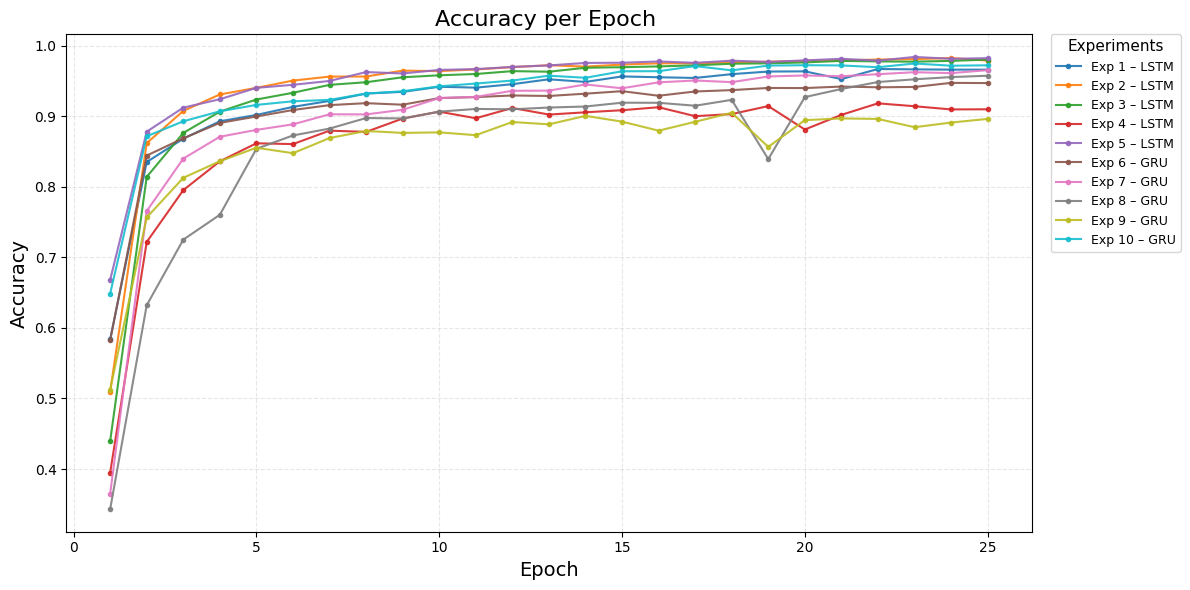

In [9]:
plot_accuracy_only(
    df,
    model_version=None,
    save_path=os.path.join(FIGURES_DIR, "accuracy_per_epoch_all.png")
)

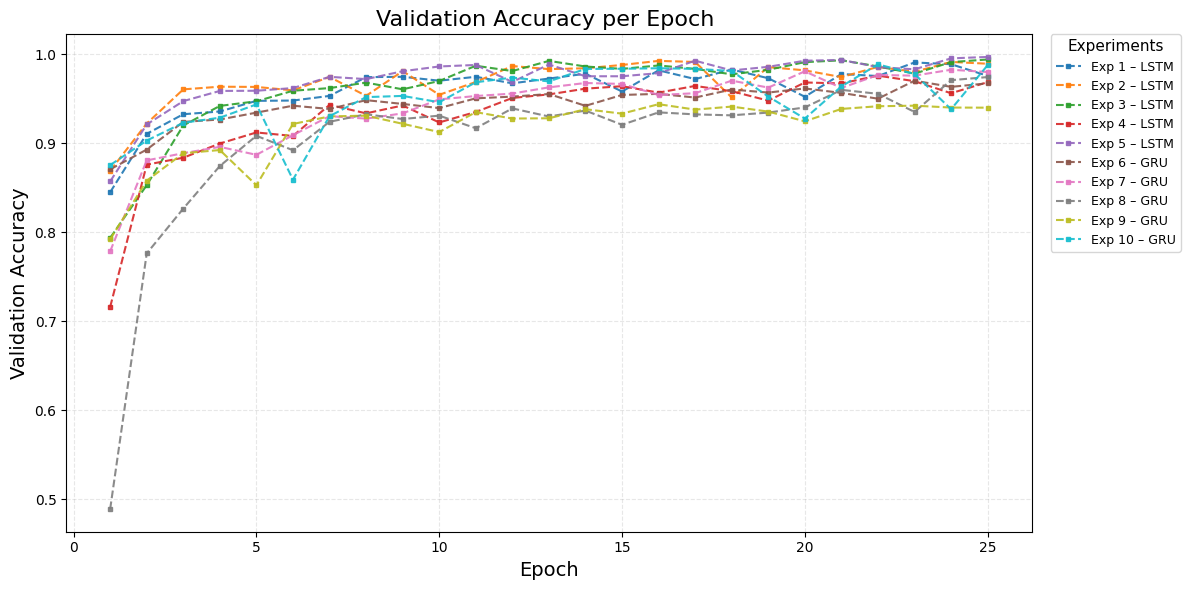

In [10]:
plot_val_accuracy_only(
    df,
    model_version=None,
    save_path=os.path.join(FIGURES_DIR, "val_accuracy_per_epoch_all.png")
)

# 📘 Cross-Validation of the Best RNN Model (5-Fold)

This notebook performs a **5-fold cross-validation** of the best-performing recurrent architecture identified in the previous experiments.  
Cross-validation is used to assess the **generalization, robustness, and stability** of the optimal model across five different data partitions.

---

## 🎯 Objectives

1. **Validate the best model architecture** (LSTM or GRU) using stratified folds.
2. Measure **accuracy**, **macro-precision**, and **macro-recall** for each fold.
3. Store:
   - The trained model for each fold
   - Evaluation metrics
   - A clean summary CSV for publication

---

## 📁 Output Structure

Cross-validation outputs will be stored here:



In [60]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# =========================================================
# Cross-validation parameters
# =========================================================

N_CLASSES = 150
N_SPLITS = 5

# Base project directory
BASE_DIR = "/Users/armandobecerril/PhD/MSL-150"

# Folder containing full .npy dataset downloaded from Zenodo
DATA_PATH = os.path.join(BASE_DIR, "data", "raw_npy")

# Folder to store trained models from CV
CV_MODELS_DIR = os.path.join(BASE_DIR, "models", "trained_models_cv")
os.makedirs(CV_MODELS_DIR, exist_ok=True)

# CSV Output path
PERF_DIR = os.path.join(BASE_DIR, "docs", "performance")
os.makedirs(PERF_DIR, exist_ok=True)

CV_CSV = os.path.join(PERF_DIR, "PERFORMANCE_LSM_MODELS_CV.csv")

# =========================================================
# Dataset already loaded from previous notebooks:
# X  -> (num_samples, 30, 226)
# y  -> one-hot (num_samples, 150)
# =========================================================

y_int = np.argmax(y, axis=1)   # for StratifiedKFold

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

acc_scores = []
prec_scores = []
rec_scores = []

cv_results = []

# Best model hyperparameters (from benchmark)
best_type = 'LSTM'
best_units = [64, 128]
best_dropout = 0.2
best_lr = 0.0005

fold = 1

for train_idx, val_idx in skf.split(X, y_int):
    print(f"\n========== Fold {fold}/{N_SPLITS} ==========")

    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    input_shape = (X_tr.shape[1], X_tr.shape[2])

    # Build model
    model = build_model(
        model_type=best_type,
        units_config=best_units,
        dropout=best_dropout,
        input_shape=input_shape,
        num_classes=N_CLASSES
    )

    model.compile(
        optimizer=Adam(learning_rate=best_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train fold
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=25,
        batch_size=64,
        callbacks=[early],
        verbose=1
    )

    # Predictions
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Fold {fold} - acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}")

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    # Save model for this fold
    fold_dir = os.path.join(CV_MODELS_DIR, f"fold_{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    model.save(os.path.join(fold_dir, "best_model.h5"))

    # Save metrics for this fold
    cv_results.append({
        "fold": fold,
        "model_type": best_type,
        "units": "-".join(map(str, best_units)),
        "learning_rate": best_lr,
        "dropout": best_dropout,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec
    })

    tf.keras.backend.clear_session()
    fold += 1

# =========================================================
# Summary
# =========================================================

print("\n===== 5-Fold Cross-Validation Summary =====")
print(f"Accuracy:          {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Precision (macro): {np.mean(prec_scores):.4f} ± {np.std(prec_scores):.4f}")
print(f"Recall (macro):    {np.mean(rec_scores):.4f} ± {np.std(rec_scores):.4f}")

# Save results CSV
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(CV_CSV, index=False)

print(f"\nCross-validation results saved to: {CV_CSV}")



========== Fold 1/5 ==========


Epoch 1/25
1444/1444 [==============================] - 45s 29ms/step - loss: 2.9240 - accuracy: 0.5366 - val_loss: 1.4632 - val_accuracy: 0.8473
Epoch 2/25
1444/1444 [==============================] - 37s 26ms/step - loss: 1.3075 - accuracy: 0.8687 - val_loss: 0.9853 - val_accuracy: 0.9238
Epoch 3/25
1444/1444 [==============================] - 37s 26ms/step - loss: 1.0083 - accuracy: 0.9041 - val_loss: 0.7855 - val_accuracy: 0.9478
Epoch 4/25
1444/1444 [==============================] - 38s 26ms/step - loss: 0.8200 - accuracy: 0.9276 - val_loss: 0.6690 - val_accuracy: 0.9524
Epoch 5/25
1444/1444 [==============================] - 38s 26ms/step - loss: 0.7326 - accuracy: 0.9351 - val_loss: 0.6222 - val_accuracy: 0.9544
Epoch 6/25
1444/1444 [==============================] - 38s 26ms/step - loss: 0.6394 - accuracy: 0.9472 - val_loss: 0.5857 - val_accuracy: 0.9543
Epoch 7/25
1444/1444 [==============================] - 38s 26ms/step - loss: 0.5897 - accuracy: 0.9512 - val_loss: 0.5083 -

/Users/armandobecerril/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



========== Fold 2/5 ==========


Epoch 1/25
1444/1444 [==============================] - 45s 29ms/step - loss: 2.9112 - accuracy: 0.5202 - val_loss: 1.4447 - val_accuracy: 0.8450
Epoch 2/25
1444/1444 [==============================] - 35s 24ms/step - loss: 1.3087 - accuracy: 0.8566 - val_loss: 0.9675 - val_accuracy: 0.9222
Epoch 3/25
1444/1444 [==============================] - 35s 25ms/step - loss: 1.0254 - accuracy: 0.8997 - val_loss: 0.8248 - val_accuracy: 0.9430
Epoch 4/25
1444/1444 [==============================] - 37s 26ms/step - loss: 0.8715 - accuracy: 0.9225 - val_loss: 0.6994 - val_accuracy: 0.9549
Epoch 5/25
1444/1444 [==============================] - 38s 26ms/step - loss: 0.7473 - accuracy: 0.9379 - val_loss: 0.6236 - val_accuracy: 0.9631
Epoch 6/25
1444/1444 [==============================] - 37s 25ms/step - loss: 0.6696 - accuracy: 0.9478 - val_loss: 0.5124 - val_accuracy: 0.9772
Epoch 7/25
1444/1444 [==============================] - 36s 25ms/step - loss: 0.6138 - accuracy: 0.9537 - val_loss: 0.5075 -

/Users/armandobecerril/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
1444/1444 [==============================] - 47s 31ms/step - loss: 2.8546 - accuracy: 0.5269 - val_loss: 1.3114 - val_accuracy: 0.8801
Epoch 2/25
1444/1444 [==============================] - 41s 28ms/step - loss: 1.2140 - accuracy: 0.8859 - val_loss: 0.9047 - val_accuracy: 0.9463
Epoch 3/25
1444/1444 [==============================] - 41s 29ms/step - loss: 0.9373 - accuracy: 0.9235 - val_loss: 0.8093 - val_accuracy: 0.9392
Epoch 4/25
1444/1444 [==============================] - 41s 29ms/step - loss: 0.7757 - accuracy: 0.9422 - val_loss: 0.6333 - val_accuracy: 0.9674
Epoch 5/25
1444/1444 [==============================] - 41s 28ms/step - loss: 0.7043 - accuracy: 0.9460 - val_loss: 0.6192 - val_accuracy: 0.9594
Epoch 6/25
1444/1444 [==============================] - 41s 28ms/step - loss: 0.6330 - accuracy: 0.9537 - val_loss: 0.5530 - val_accuracy: 0.9638
Epoch 7/25
1444/1444 [==============================] - 41s 29ms/step - loss: 0.5755 - accuracy: 0.9608 - val_loss: 0.5054 -

/Users/armandobecerril/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



========== Fold 4/5 ==========


Epoch 1/25
1444/1444 [==============================] - 49s 31ms/step - loss: 2.7366 - accuracy: 0.5835 - val_loss: 1.3013 - val_accuracy: 0.8786
Epoch 2/25
1444/1444 [==============================] - 37s 26ms/step - loss: 1.1950 - accuracy: 0.8872 - val_loss: 0.8866 - val_accuracy: 0.9493
Epoch 3/25
1444/1444 [==============================] - 37s 26ms/step - loss: 0.9085 - accuracy: 0.9283 - val_loss: 0.7298 - val_accuracy: 0.9601
Epoch 4/25
1444/1444 [==============================] - 37s 26ms/step - loss: 0.7590 - accuracy: 0.9438 - val_loss: 0.6006 - val_accuracy: 0.9696
Epoch 5/25
1444/1444 [==============================] - 37s 26ms/step - loss: 0.6720 - accuracy: 0.9502 - val_loss: 0.5546 - val_accuracy: 0.9676
Epoch 6/25
1444/1444 [==============================] - 37s 26ms/step - loss: 0.6036 - accuracy: 0.9568 - val_loss: 0.5596 - val_accuracy: 0.9572
Epoch 7/25
1444/1444 [==============================] - 37s 26ms/step - loss: 0.5541 - accuracy: 0.9600 - val_loss: 0.4389 -

/Users/armandobecerril/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
1444/1444 [==============================] - 54s 36ms/step - loss: 2.7435 - accuracy: 0.5752 - val_loss: 1.2700 - val_accuracy: 0.8916
Epoch 2/25
1444/1444 [==============================] - 48s 33ms/step - loss: 1.2019 - accuracy: 0.8877 - val_loss: 0.8908 - val_accuracy: 0.9422
Epoch 3/25
1444/1444 [==============================] - 46s 32ms/step - loss: 0.9537 - accuracy: 0.9187 - val_loss: 0.7112 - val_accuracy: 0.9641
Epoch 4/25
1444/1444 [==============================] - 46s 32ms/step - loss: 0.7865 - accuracy: 0.9395 - val_loss: 0.6543 - val_accuracy: 0.9611
Epoch 5/25
1444/1444 [==============================] - 45s 31ms/step - loss: 0.6975 - accuracy: 0.9477 - val_loss: 0.5604 - val_accuracy: 0.9714
Epoch 6/25
1444/1444 [==============================] - 45s 31ms/step - loss: 0.6305 - accuracy: 0.9549 - val_loss: 0.5323 - val_accuracy: 0.9728
Epoch 7/25
1444/1444 [==============================] - 42s 29ms/step - loss: 0.5826 - accuracy: 0.9589 - val_loss: 0.4876 -

/Users/armandobecerril/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



===== 5-Fold Cross-Validation Summary =====
Accuracy:          0.9915 ± 0.0069
Precision (macro): 0.9837 ± 0.0035
Recall (macro):    0.9809 ± 0.0058

Cross-validation results saved to: /Users/armandobecerril/PhD/MSL-150/docs/performance/PERFORMANCE_LSM_MODELS_CV.csv


# Carga de CSV base vs. cross-validation

In [12]:
import os
import pandas as pd

# Base project dir
BASE_DIR = "/Users/armandobecerril/PhD/MSL-150"

# Performance directories and files
PERFORMANCE_DIR = os.path.join(BASE_DIR, "docs", "performance")
BASE_CSV = os.path.join(PERFORMANCE_DIR, "PERFORMANCE_LSM_MODELS.csv")
CV_CSV   = os.path.join(PERFORMANCE_DIR, "PERFORMANCE_LSM_MODELS_CV.csv")

# Read both CSVs
df_base = pd.read_csv(BASE_CSV)
df_cv   = pd.read_csv(CV_CSV)

print("Base 80/20 shape:", df_base.shape)
print("CV shape:", df_cv.shape)

display(df_base.head())
display(df_cv.head())


Base 80/20 shape: (250, 15)
CV shape: (5, 8)


,experiment_id,model_version,model_type,units,learning_rate,batch_size,epochs,dropout,epoch,accuracy,val_accuracy,precision,recall,auc,early_stopping
0,1,NaN,LSTM,128,0.001,32,25,NaN,1,0.583802,0.844735,0.975758,0.962237,0.999913,False
1,1,NaN,LSTM,128,0.001,32,25,NaN,2,0.835112,0.910331,0.975758,0.962237,0.999913,False
2,1,NaN,LSTM,128,0.001,32,25,NaN,3,0.868159,0.932369,0.975758,0.962237,0.999913,False
3,1,NaN,LSTM,128,0.001,32,25,NaN,4,0.892828,0.935443,0.975758,0.962237,0.999913,False
4,1,NaN,LSTM,128,0.001,32,25,NaN,5,0.901823,0.947393,0.975758,0.962237,0.999913,False


,fold,model_type,units,learning_rate,dropout,accuracy,precision_macro,recall_macro
0,1,LSTM,64-128,0.0005,0.2,0.995584,0.982243,0.982112
1,2,LSTM,64-128,0.0005,0.2,0.977788,0.978777,0.969659
2,3,LSTM,64-128,0.0005,0.2,0.995714,0.988734,0.985862
3,4,LSTM,64-128,0.0005,0.2,0.995237,0.982007,0.982125
4,5,LSTM,64-128,0.0005,0.2,0.992986,0.986559,0.984822


Seleccionar el mejor modelo 80/20 (LSTM 64–128)

Mantenemos tu lógica: filtrar por model_type == 'LSTM' y units == '64-128', y tomar la fila con mejor val_accuracy

In [23]:
import os
import numpy as np
import pandas as pd

# ============================
# Paths
# ============================
BASE_DIR        = "/Users/armandobecerril/PhD/MSL-150"
PERFORMANCE_DIR = os.path.join(BASE_DIR, "docs", "performance")

CSV_SINGLE = os.path.join(PERFORMANCE_DIR, "PERFORMANCE_LSM_MODELS.csv")
CSV_CV     = os.path.join(PERFORMANCE_DIR, "PERFORMANCE_LSM_MODELS_CV.csv")

# ============================
# 1) Resumen 80/20 por experimento
# ============================
perf = pd.read_csv(CSV_SINGLE)

summary_rows = []
for exp_id, g in perf.groupby("experiment_id"):
    g_sorted = g.sort_values("epoch")
    last = g_sorted.iloc[-1]  # última época

    summary_rows.append({
        "experiment_id": exp_id,
        "model_type": last["model_type"],
        "units": str(last["units"]),
        "learning_rate": last["learning_rate"],
        "batch_size": last["batch_size"],
        "epochs": last["epochs"],
        "dropout": last["dropout"],
        "accuracy_train": last["accuracy"],      # entrenamiento
        "val_accuracy": last["val_accuracy"],    # validación
        "precision_test": last["precision"],     # test (macro)
        "recall_test": last["recall"],           # test (macro)
    })

summary = pd.DataFrame(summary_rows)

# Mejor LSTM según precision_test (test set)
best_lstm = (
    summary[summary["model_type"] == "LSTM"]
    .sort_values("precision_test", ascending=False)
    .iloc[0]
)

print("Best LSTM (80/20) based on test precision:")
print(best_lstm)


Best LSTM (80/20) based on test precision:
experiment_id            5
model_type            LSTM
units              128-128
learning_rate        0.001
batch_size              64
epochs                  25
dropout                0.1
accuracy_train    0.982324
val_accuracy      0.996709
precision_test    0.996164
recall_test       0.991689
Name: 4, dtype: object


In [24]:
# ============================
# 2) Resultados de 5-fold CV
# ============================
cv = pd.read_csv(CSV_CV)

cv_means = cv[["accuracy", "precision_macro", "recall_macro"]].mean()
cv_stds  = cv[["accuracy", "precision_macro", "recall_macro"]].std(ddof=1)  # sample std

print("\n5-fold CV means:")
print(cv_means)
print("\n5-fold CV stds:")
print(cv_stds)



5-fold CV means:
accuracy           0.991462
precision_macro    0.983664
recall_macro       0.980916
dtype: float64

5-fold CV stds:
accuracy           0.007723
precision_macro    0.003960
recall_macro       0.006506
dtype: float64


In [25]:
# ============================
# 3) Tabla comparativa
# ============================

row_single = {
    "Setting": "Single 80/20 split (best LSTM)",
    # Usamos val_accuracy como proxy de accuracy global (las otras métricas son de test)
    "Accuracy":        best_lstm["val_accuracy"],
    "Precision_macro": best_lstm["precision_test"],
    "Recall_macro":    best_lstm["recall_test"],
    "Accuracy_std":    np.nan,
    "Precision_std":   np.nan,
    "Recall_std":      np.nan,
}

row_cv = {
    "Setting": "5-fold cross-validation (best LSTM)",
    "Accuracy":        cv_means["accuracy"],
    "Precision_macro": cv_means["precision_macro"],
    "Recall_macro":    cv_means["recall_macro"],
    "Accuracy_std":    cv_stds["accuracy"],
    "Precision_std":   cv_stds["precision_macro"],
    "Recall_std":      cv_stds["recall_macro"],
}

comparison_df = pd.DataFrame([row_single, row_cv])
print("\nComparison table (raw):")
print(comparison_df)



Comparison table (raw):
                               Setting  Accuracy  Precision_macro  \
0       Single 80/20 split (best LSTM)  0.996709         0.996164   
1  5-fold cross-validation (best LSTM)  0.991462         0.983664   

   Recall_macro  Accuracy_std  Precision_std  Recall_std  
0      0.991689           NaN            NaN         NaN  
1      0.980916      0.007723        0.00396    0.006506  


In [26]:
def comparison_to_latex(df):
    fmt_df = df.copy()
    float_cols = [
        "Accuracy", "Precision_macro", "Recall_macro",
        "Accuracy_std", "Precision_std", "Recall_std"
    ]
    for col in float_cols:
        fmt_df[col] = fmt_df[col].map(
            lambda x: "" if pd.isna(x) else f"{x:.6f}"
        )

    # Orden de columnas
    cols = [
        "Setting",
        "Accuracy", "Precision_macro", "Recall_macro",
        "Accuracy_std", "Precision_std", "Recall_std"
    ]

    latex_str = fmt_df[cols].to_latex(
        index=False,
        escape=True,
        column_format="lcccccc"
    )
    return latex_str

latex_table = comparison_to_latex(comparison_df)
print("\nLaTeX table:\n")
print(latex_table)



LaTeX table:

\begin{tabular}{lcccccc}
\toprule
Setting & Accuracy & Precision\_macro & Recall\_macro & Accuracy\_std & Precision\_std & Recall\_std \\
\midrule
Single 80/20 split (best LSTM) & 0.996709 & 0.996164 & 0.991689 &  &  &  \\
5-fold cross-validation (best LSTM) & 0.991462 & 0.983664 & 0.980916 & 0.007723 & 0.003960 & 0.006506 \\
\bottomrule
\end{tabular}



Resumen de cross-validation

Gráfico 1 – 80/20 vs 5-fold CV (con barras y error bars, 600 dpi)

Figura en docs/figures/best_lstm_8020_vs_cv.png

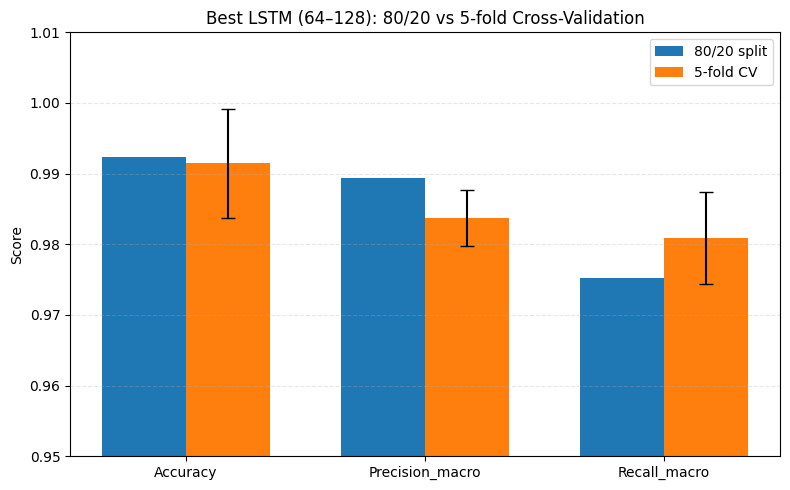

Saved PNG:  /Users/armandobecerril/PhD/MSL-150/docs/figures/best_lstm_8020_vs_cv.png
Saved PDF:  /Users/armandobecerril/PhD/MSL-150/docs/figures/best_lstm_8020_vs_cv.pdf


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure figures directory exists
FIG_DIR = os.path.join(BASE_DIR, "docs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

metrics = ["Accuracy", "Precision_macro", "Recall_macro"]
values_8020 = [acc_8020, prec_8020, rec_8020]
values_cv   = [acc_cv_mean, prec_cv_mean, rec_cv_mean]
errors_cv   = [acc_cv_std, prec_cv_std, rec_cv_std]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, values_8020, width, label="80/20 split")
plt.bar(x + width/2, values_cv, width, yerr=errors_cv, capsize=5, label="5-fold CV")

plt.xticks(x, metrics)
plt.ylim(0.95, 1.01)
plt.ylabel("Score")
plt.title("Best LSTM (64–128): 80/20 vs 5-fold Cross-Validation")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

# -------------------------------------
# EXPORT: PNG (600 dpi) AND PDF
# -------------------------------------
fname = "best_lstm_8020_vs_cv"

png_path = os.path.join(FIG_DIR, f"{fname}.png")
pdf_path = os.path.join(FIG_DIR, f"{fname}.pdf")

plt.savefig(png_path, dpi=600, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")   # vector quality

plt.show()

print("Saved PNG: ", png_path)
print("Saved PDF: ", pdf_path)


Gráfico 2 – Métricas por fold (accuracy / precision / recall), 600 dpi

Figura en docs/figures/best_lstm_cv_metrics_per_fold.png

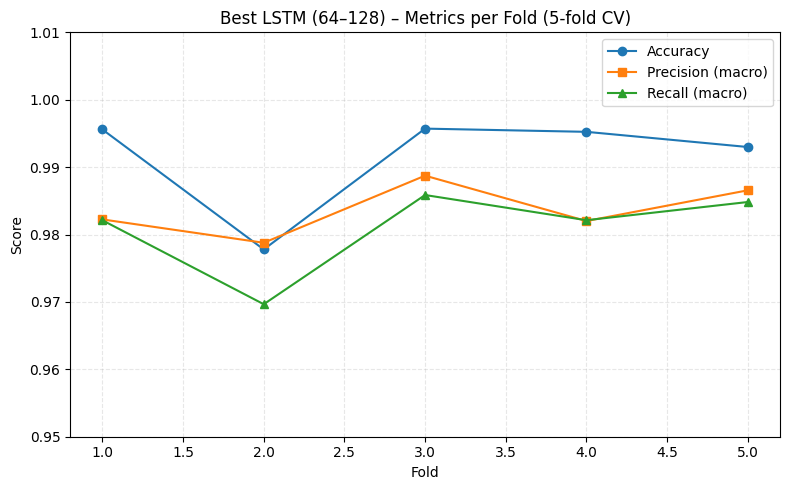

Saved PNG: /Users/armandobecerril/PhD/MSL-150/docs/figures/best_lstm_cv_metrics_per_fold.png
Saved PDF: /Users/armandobecerril/PhD/MSL-150/docs/figures/best_lstm_cv_metrics_per_fold.pdf


In [17]:
import os
import matplotlib.pyplot as plt

# Ensure figures directory exists
FIG_DIR = os.path.join(BASE_DIR, "docs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

plt.figure(figsize=(8, 5))

plt.plot(df_cv["fold"], df_cv["accuracy"], marker="o", label="Accuracy")
plt.plot(df_cv["fold"], df_cv["precision_macro"], marker="s", label="Precision (macro)")
plt.plot(df_cv["fold"], df_cv["recall_macro"], marker="^", label="Recall (macro)")

plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Best LSTM (64–128) – Metrics per Fold (5-fold CV)")
plt.ylim(0.95, 1.01)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()

# ----------------------------------------------------------
# Export both PNG (600 dpi) and PDF (vector format)
# ----------------------------------------------------------
fname = "best_lstm_cv_metrics_per_fold"

png_path = os.path.join(FIG_DIR, f"{fname}.png")
pdf_path = os.path.join(FIG_DIR, f"{fname}.pdf")

plt.savefig(png_path, dpi=600, bbox_inches="tight")  # High resolution PNG
plt.savefig(pdf_path, bbox_inches="tight")           # Perfect vector PDF

plt.show()

print("Saved PNG:", png_path)
print("Saved PDF:", pdf_path)
